In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score

#### DATA UNDERSTANDING & LOADING ####

In [ ]:
# Load the dataset
df = pd.read_csv('online_retail_II.csv')

In [19]:
print("Initial Data Shape:", df.shape)
print("Columns:", df.columns)

Initial Data Shape: (1048575, 8)
Columns: Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


#### DATA CLEANING & PREPARATION ####

In [20]:
# Count missing values per column
df.isnull().sum()


Invoice             0
StockCode           0
Description      4372
Quantity            0
InvoiceDate         0
Price               0
Customer ID    236682
Country             0
dtype: int64

In [21]:
# Show percentage of missing values
(df.isnull().sum() / len(df)) * 100

Invoice         0.000000
StockCode       0.000000
Description     0.416947
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.571776
Country         0.000000
dtype: float64

In [22]:
# Show only columns with missing values
df.isnull().sum()[df.isnull().sum() > 0]


Description      4372
Customer ID    236682
dtype: int64

##### Handling Missing Values #####

In [ ]:
# Drop rows without 'Customer ID' because we cannot profile anonymous customers.
# This aligns with the strategy of removing incomplete records for critical features.
df.dropna(subset=['Customer ID'], inplace=True)

In [25]:
# After Handling Count missing values per column
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [26]:
# For 'Description', if any are missing, we fill with a placeholder or Mode
df['Description'] = df['Description'].fillna('Unknown')

##### Filtering Anomalies & Cancellations #####

In [27]:
# Remove cancelled orders (Invoice containing 'C') and negative quantities
df = df[~df['Invoice'].astype(str).str.contains('C')]
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

##### Feature Engineering #####

In [28]:
# Create 'TotalPrice' for financial analysis
df['TotalPrice'] = df['Quantity'] * df['Price']
# Convert Date to datetime object
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Cleaned Data Shape:", df.shape)

Cleaned Data Shape: (793309, 9)


#### FEATURE ENGINEERING: RFM ANALYSIS ####

In [ ]:
# Create a customer-centric view (Recency, Frequency, Monetary)
# This aggregates the transaction data into unique customer profiles.

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)



In [31]:
customers = df.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # For Recency
    'Invoice': 'nunique',                                    # For Frequency
    'TotalPrice': 'sum'                                      # For Monetary
})

In [32]:
# Rename columns for clarity
customers.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

print(customers.head())

             Recency  Frequency  Monetary
Customer ID                              
12346.0          321         12  77556.46
12347.0           35          7   5408.50
12348.0           71          5   2019.40
12349.0           14          4   4428.69
12350.0          305          1    334.40


#### EXPLORATORY DATA ANALYSIS (EDA) & VISUALIZATION ####

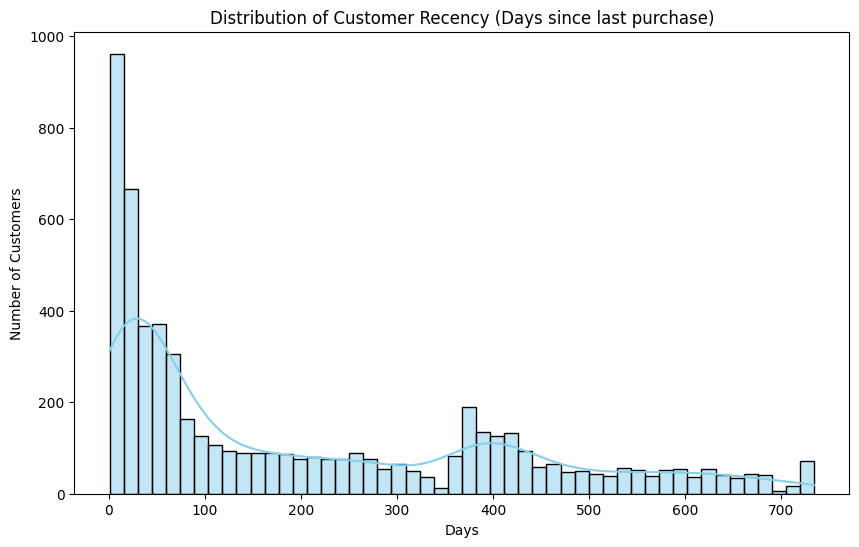

In [33]:
#Histogram (Distribution of Recency)
plt.figure(figsize=(10, 6))
sns.histplot(customers['Recency'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Customer Recency (Days since last purchase)')
plt.xlabel('Days')
plt.ylabel('Number of Customers')
plt.show()

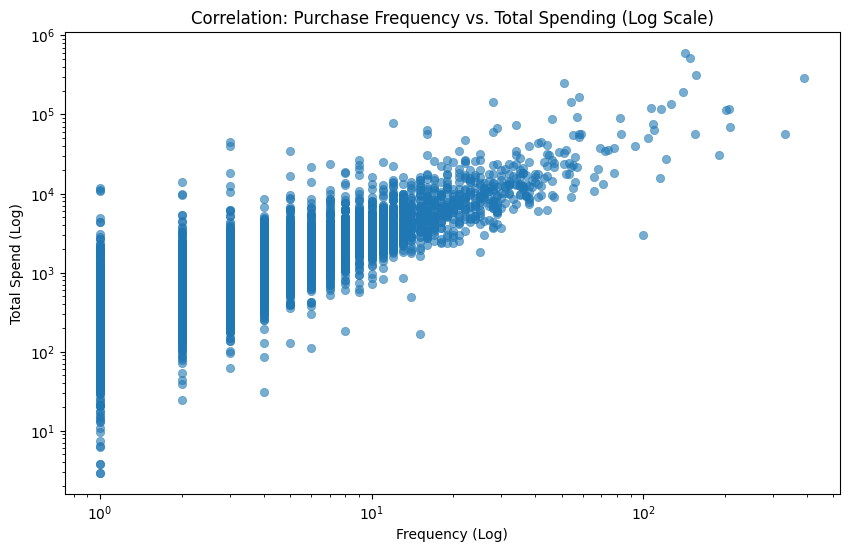

In [34]:
#Scatter Plot (Frequency vs. Monetary) with Log Scale
# Log scale handles the high skewness/variance in retail data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customers, x='Frequency', y='Monetary', alpha=0.6, edgecolor=None)
plt.xscale('log')
plt.yscale('log')
plt.title('Correlation: Purchase Frequency vs. Total Spending (Log Scale)')
plt.xlabel('Frequency (Log)')
plt.ylabel('Total Spend (Log)')
plt.show()

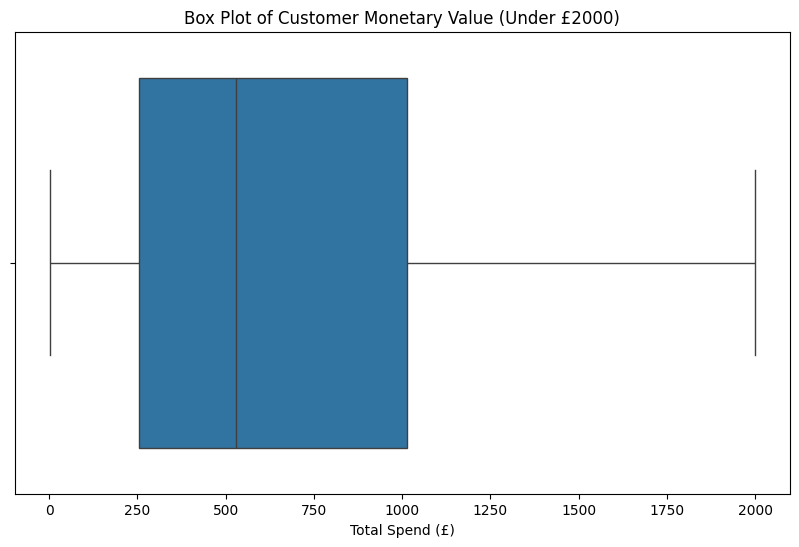

In [35]:
#Box Plot (Outlier Detection)
# Checking the spread of monetary value (capped at 2000 for visibility)
plt.figure(figsize=(10, 6))
sns.boxplot(x=customers[customers['Monetary'] < 2000]['Monetary'])
plt.title('Box Plot of Customer Monetary Value (Under £2000)')
plt.xlabel('Total Spend (£)')
plt.show()

#### UNSUPERVISED LEARNING: K-MEANS CLUSTERING ####

In [36]:
# Normalize the data (K-Means requires scaled data)
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers)

In [39]:
# Fit K-Means with k=3 (Example cluster count)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)


In [40]:
customers['Cluster'] = kmeans.fit_predict(customers_scaled)

/Users/yuvindu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/yuvindu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/yuvindu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/yuvindu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/yuvindu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/yuvindu/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = cl

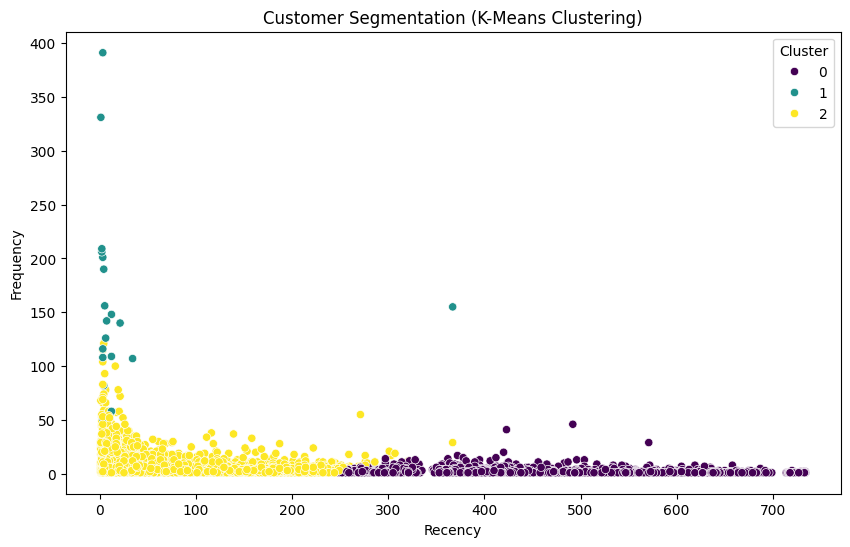

In [41]:
# Visualization 4: Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customers, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation (K-Means Clustering)')
plt.show()

#### Adding DBSCAN ####

In [ ]:
#Initialize the Model
dbscan = DBSCAN(eps=0.5, min_samples=5)

In [ ]:
# Fit the Model
clusters_dbscan = dbscan.fit_predict(customers_scaled)
customers['DBSCAN_Cluster'] = clusters_dbscan

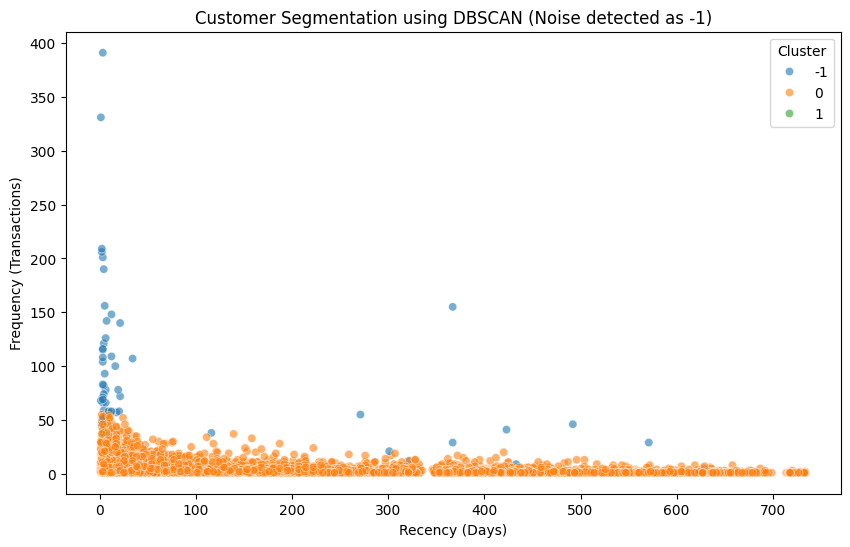

In [61]:
#Visualization: DBSCAN Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customers, x='Recency', y='Frequency', hue='DBSCAN_Cluster', palette='tab10', alpha=0.6)
plt.title('Customer Segmentation using DBSCAN (Noise detected as -1)')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (Transactions)')
plt.legend(title='Cluster')
plt.show()

In [62]:
#Analysis of Outliers
n_outliers = list(clusters_dbscan).count(-1)
print(f"DBSCAN detected {n_outliers} outliers (Cluster -1).")
print("These customers represent anomalous buying behavior compared to the majority.")

DBSCAN detected 58 outliers (Cluster -1).
These customers represent anomalous buying behavior compared to the majority.
